In [1]:
import os
import pandas as pd
import numpy as np
import re
import html
from bs4 import BeautifulSoup
import emoji
import nltk
import gensim.downloader as gdownload
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# === NLTK Setup ===
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('omw-1.4')

# === PATH SETUP ===
DATA_DIR = "data"
DISLIKE_FILE = os.path.join(DATA_DIR, "youtube_dislike_dataset.csv")


[nltk_data] Downloading package words to
[nltk_data]     /home/schwandersc/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/schwandersc/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/schwandersc/nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/schwandersc/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/schwandersc/nltk_data...


In [5]:
# === STEP 1: Load All Comment Files ===
df_chris = pd.read_csv(os.path.join(DATA_DIR, "chris_comments.csv"))
df_charlie = pd.read_csv(os.path.join(DATA_DIR, "Charlie_merged_comments.csv"))
df_cici = pd.read_csv(os.path.join(DATA_DIR, "merged_comments_cici_actual.csv"))
df_jz = pd.read_csv(os.path.join(DATA_DIR, "merged_data_jz.csv"))

# Only use top-level comments for Charlie's data
df_charlie = df_charlie[df_charlie['parentId'].isnull()]

# Keep consistent columns for Cici data
df_cici = df_cici[[
    'channelId', 'videoId', 'textDisplay', 'textOriginal', 'parentId',
    'authorDisplayName', 'authorProfileImageUrl', 'authorChannelUrl',
    'authorChannelId', 'canRate', 'viewerRating', 'likeCount',
    'publishedAt', 'updatedAt', 'commentId'
]]

# Combine all datasets
combined_df = pd.concat([df_charlie, df_cici, df_jz, df_chris], ignore_index=True)


/tmp/ipykernel_100672/3410962717.py:4: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cici = pd.read_csv(os.path.join(DATA_DIR, "merged_comments_cici_actual.csv"))


In [7]:
combined_df.drop(columns=[
    'parentId', 'authorProfileImageUrl', 'authorChannelUrl',
    'authorChannelId', 'canRate', 'viewerRating'
], inplace=True, errors='ignore')

# Drop null comments
combined_df = combined_df[combined_df['textDisplay'].notnull()]
combined_df.to_csv(os.path.join(DATA_DIR, "all_comments_merged_cut.csv"), index=False)


In [9]:
def clean_text(text):
    text = re.sub(r'<!--(.*?)-->', '', text)
    text = re.sub(r'<i>(.*?)</i>', r'\1', text)
    text = re.sub(r'<a(.*?)>(.*?)</a>', r'\2', text)
    text = html.unescape(text)
    return emoji.demojize(BeautifulSoup(text, 'html.parser').get_text(separator='\n'))

combined_df['textDisplay'] = combined_df['textDisplay'].str.replace(r'@\w+', '', regex=True)
combined_df['textDisplay'] = combined_df['textDisplay'].apply(clean_text)
combined_df.to_pickle(os.path.join(DATA_DIR, "merged_comments.pkl"))

# === STEP 3: Tokenize & Embed Comments ===
wordset = set(words.words())
stopwordset = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenizer(sentence):
    return [
        lemmatizer.lemmatize(word.lower())
        for word in sentence.split()
        if word.lower() in wordset and word.lower() not in stopwordset
    ]

df_filtered = combined_df[combined_df['likeCount'] != 0].copy()
df_filtered['wordtoken'] = df_filtered['textDisplay'].apply(tokenizer)


/tmp/ipykernel_100672/2738100307.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df['textDisplay'] = combined_df['textDisplay'].str.replace(r'@\w+', '', regex=True)
/tmp/ipykernel_100672/2738100307.py:6: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this

In [11]:

glove_model = gdownload.load('glove-twitter-50')

def sentence_embed(sentence, model):
    if not sentence:
        return np.zeros(50)
    return sum((model[word] if word in model else np.zeros(50) for word in sentence), np.zeros(50)) / len(sentence)


df_filtered['word_vector'] = df_filtered['wordtoken'].apply(lambda x: sentence_embed(x, glove_model))
df_filtered['tokenlength'] = df_filtered['wordtoken'].apply(len)
df_filtered = df_filtered[df_filtered['tokenlength'] > 0]


ValueError: Length mismatch: Expected axis has 12 elements, new values have 14 elements

In [33]:

# === STEP 4: Merge Dislike Data ===
dislikes = pd.read_csv(DISLIKE_FILE)
dislikes = dislikes.copy()
dislikes['likes'] = dislikes['likes'].replace(0, np.nan)
dislikes['dislikes'] = dislikes['dislikes'].replace(0, np.nan)

# Step 1: Compute ratio
dislikes['ratio'] = dislikes['likes'] / dislikes['dislikes']

# Step 2: Compute log-normalized ratio
dislikes['norm_ratio'] = np.log(dislikes['ratio'])

# Optional: Replace inf/-inf with NaN and drop rows with missing values if needed
dislikes.replace([np.inf, -np.inf], np.nan, inplace=True)
dislikes.dropna(subset=['norm_ratio'], inplace=True)


In [36]:
dislikes.columns

Index(['video_id', 'title', 'channel_id', 'channel_title', 'published_at',
       'view_count', 'likes', 'dislikes', 'comment_count', 'tags',
       'description', 'comments', 'ratio', 'norm_ratio'],
      dtype='object')

In [37]:

dislikes.columns = ['videoId', 'title', 'channel_id', 'channel_title', 'published_at',
       'view_count', 'likes', 'dislikes', 'comment_count', 'tags',
       'description', 'comments', 'ratio', 'norm_ratio']

df_merged = pd.merge(df_filtered, dislikes, on='videoId', how='inner')
df_merged = df_merged[[
    'videoId', 'textDisplay', 'likeCount', 'wordtoken', 'word_vector',
    'tokenlength', 'title', 'view_count', 'likes', 'dislikes',
    'comment_count', 'ratio', 'norm_ratio'
]]

df_merged.to_pickle(os.path.join(DATA_DIR, "comment_and_vid_data.pkl"))


In [38]:
# === STEP 5: Sentiment Analysis ===
sia = SentimentIntensityAnalyzer()
df_merged['sentiment'] = df_merged['textDisplay'].apply(
    lambda text: 'positive' if sia.polarity_scores(text)['compound'] > 0.2 else
                 'negative' if sia.polarity_scores(text)['compound'] < -0.2 else
                 'neutral'
)

df_merged.to_pickle(os.path.join(DATA_DIR, "comments_and_all_sentiment.pkl"))


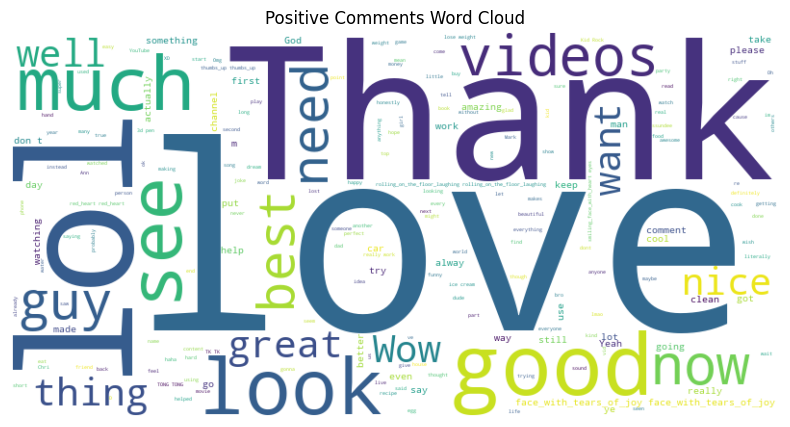

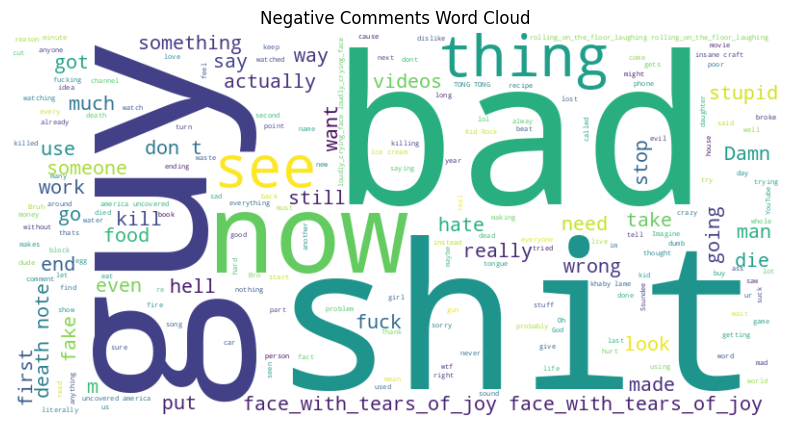

In [61]:
df = pd.read_pickle(os.path.join(DATA_DIR, "comments_and_all_sentiment.pkl"))

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def plot_wordcloud(df, sentiment_label, extra_stopwords=None):
    comments = df['textDisplay'][df['sentiment'] == sentiment_label]
    text = " ".join(comments)

    custom_stopwords = set([
        "a", "the", "and", "is", "with", "this", "video", "people", "s", "one",
        "will", "know", "think", "make", "u", "time"
    ])
    if extra_stopwords:
        custom_stopwords.update(extra_stopwords)

    stopwords = STOPWORDS.union(custom_stopwords)
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment_label.capitalize()} Comments Word Cloud')
    plt.show()

# Example usage:
plot_wordcloud(df, "positive")
plot_wordcloud(df, "negative")


In [62]:

df = pd.get_dummies(df, columns=['sentiment'], prefix='comment_class')

# Aggregate sentiment stats per video
sentiment_sums = df.groupby('videoId')[
    ['comment_class_negative', 'comment_class_neutral', 'comment_class_positive']
].sum()

# Take max norm_ratio per video
ratios = df[['videoId', 'norm_ratio']].groupby('videoId').max()

# Merge for training data
train_df = pd.merge(sentiment_sums, ratios, on='videoId')
train_df.to_pickle("data/sentiment_data.pkl")

# Reload and merge like/view data
train_df = pd.read_pickle("data/sentiment_data.pkl")
dislikes = pd.read_csv("data/youtube_dislike_dataset.csv")
dislikes['like-view'] = dislikes['likes'] / dislikes['view_count']
like_view = dislikes[['video_id', 'like-view']]

train_df = train_df.merge(like_view, left_index=True, right_on='video_id', how='left')

# Normalize sentiment columns
train_df['total_comments'] = (
    train_df['comment_class_negative'] +
    train_df['comment_class_neutral'] +
    train_df['comment_class_positive']
)

for col in ['comment_class_negative', 'comment_class_neutral', 'comment_class_positive']:
    train_df[col] = train_df[col] / train_df['total_comments']


In [63]:

# Create categorical target from norm_ratio
bins = [0, 2.5, 4, 8]
labels = ['Negative', 'Neutral', 'Positive']
# Ensure norm_ratio is numeric
train_df['norm_ratio'] = pd.to_numeric(train_df['norm_ratio'], errors='coerce')

# Drop rows with NaN norm_ratio (caused by invalid strings or missing values)
train_df = train_df.dropna(subset=['norm_ratio'])

train_df['video_type'] = pd.cut(train_df['norm_ratio'], bins=bins, labels=labels, include_lowest=True)
train_df['video_type_clean'] = train_df['video_type'].map({'Negative': -1, 'Neutral': 0, 'Positive': 1})

train_df = train_df.dropna()

# Feature matrix and target
X = train_df[['comment_class_negative', 'comment_class_neutral', 'comment_class_positive', 'like-view']]
y = train_df['video_type_clean']


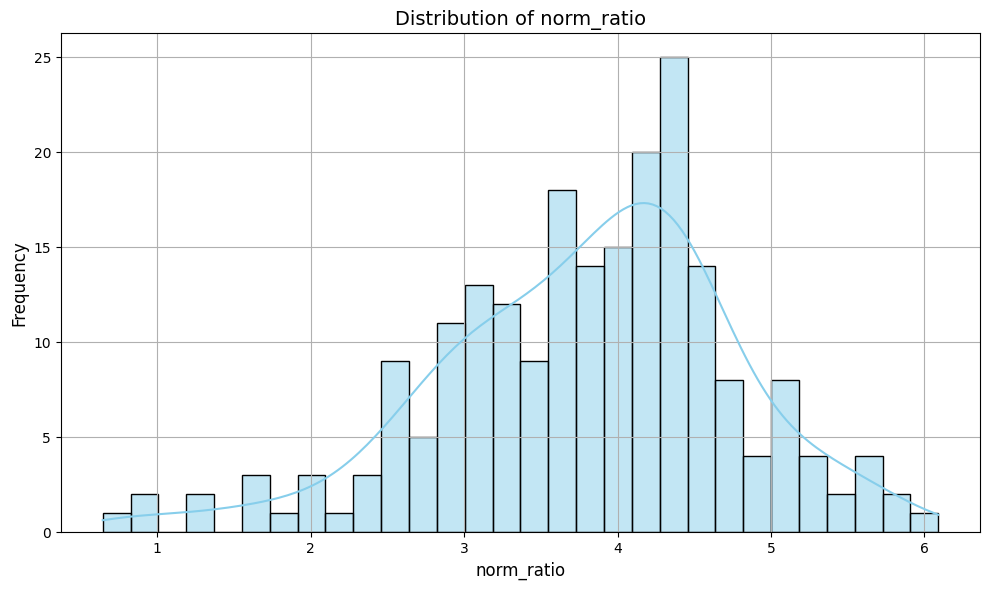

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(train_df['norm_ratio'], bins=30, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribution of norm_ratio', fontsize=14)
plt.xlabel('norm_ratio', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Decision Tree Accuracy: 0.5814
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.54      0.37      0.44        19
           1       0.67      0.90      0.77        20

    accuracy                           0.58        43
   macro avg       0.40      0.42      0.40        43
weighted avg       0.55      0.58      0.55        43



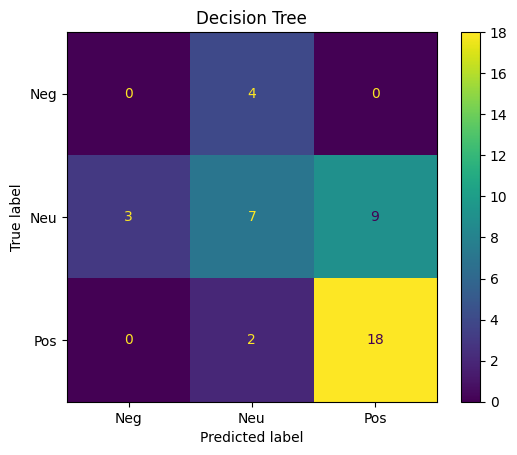

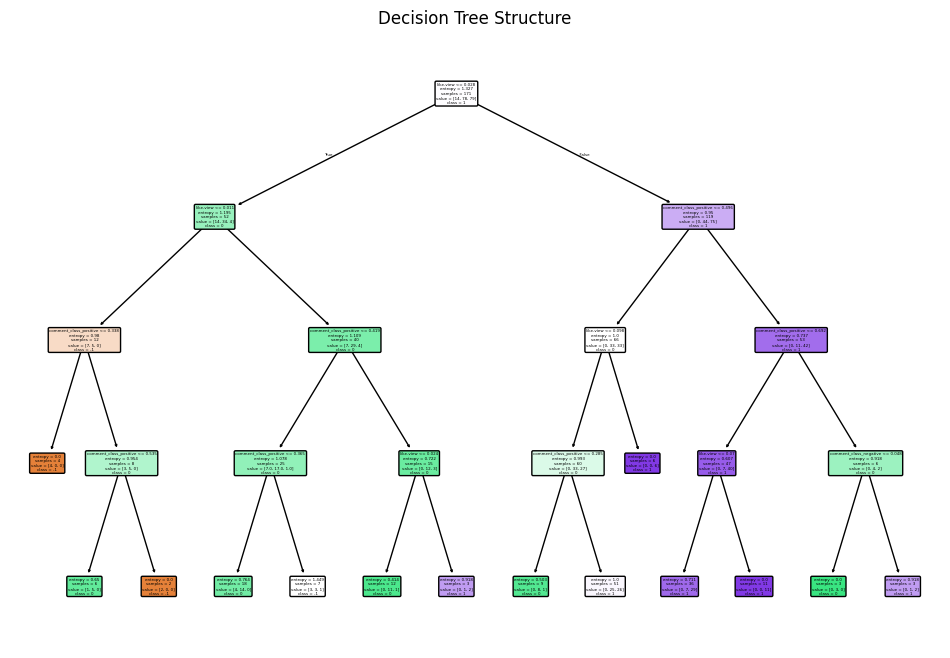

In [65]:

# Train/test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2023)

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

def evaluate_model(model, model_name):
    y_pred = model.predict(x_test)
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Neg', 'Neu', 'Pos'])
    plt.title(model_name)
    plt.show()

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Decision Tree
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=2023)
tree.fit(x_train, y_train)
evaluate_model(tree, "Decision Tree")

plt.figure(figsize=(12, 8))
plot_tree(tree, feature_names=X.columns, class_names=['-1', '0', '1'], filled=True, rounded=True)
plt.title("Decision Tree Structure")
plt.show()

Gradient Boosting Classifier Accuracy: 0.6512
Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.25      0.33         4
           0       0.59      0.68      0.63        19
           1       0.74      0.70      0.72        20

    accuracy                           0.65        43
   macro avg       0.61      0.54      0.56        43
weighted avg       0.65      0.65      0.65        43



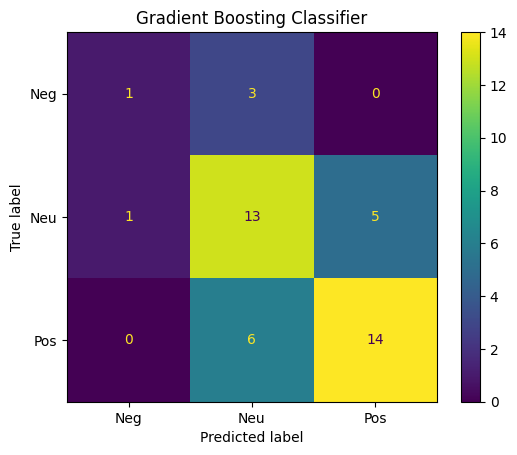

In [66]:

# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=80, learning_rate=0.2, max_depth=3, random_state=2023)
gb.fit(x_train, y_train)
evaluate_model(gb, "Gradient Boosting Classifier")


Random Forest Classifier Accuracy: 0.6744
Classification Report:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           0       0.62      0.68      0.65        19
           1       0.76      0.80      0.78        20

    accuracy                           0.67        43
   macro avg       0.46      0.49      0.48        43
weighted avg       0.63      0.67      0.65        43



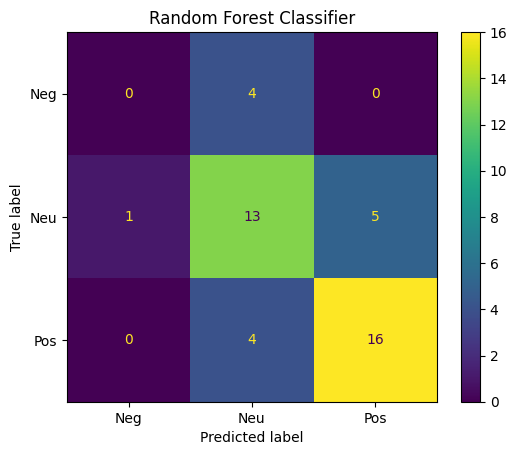

In [67]:

rf = RandomForestClassifier(n_estimators=1000, random_state=2023)
rf.fit(x_train, y_train)
evaluate_model(rf, "Random Forest Classifier")


Decision Tree (SMOTE) Accuracy: 0.5116
Classification Report:
              precision    recall  f1-score   support

          -1       0.33      0.50      0.40         4
           0       0.46      0.63      0.53        19
           1       0.73      0.40      0.52        20

    accuracy                           0.51        43
   macro avg       0.51      0.51      0.48        43
weighted avg       0.57      0.51      0.51        43



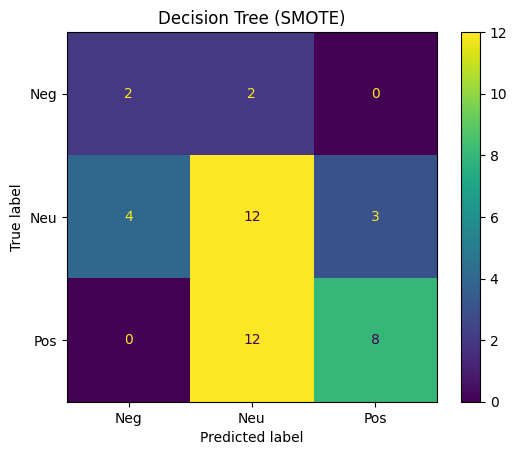

Gradient Boosting (SMOTE) Accuracy: 0.6047
Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.25      0.25         4
           0       0.55      0.58      0.56        19
           1       0.74      0.70      0.72        20

    accuracy                           0.60        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.61      0.60      0.61        43



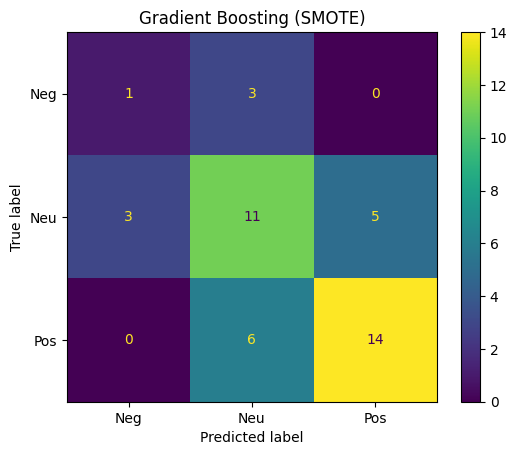

Random Forest (SMOTE) Accuracy: 0.6047
Classification Report:
              precision    recall  f1-score   support

          -1       0.25      0.25      0.25         4
           0       0.55      0.58      0.56        19
           1       0.74      0.70      0.72        20

    accuracy                           0.60        43
   macro avg       0.51      0.51      0.51        43
weighted avg       0.61      0.60      0.61        43



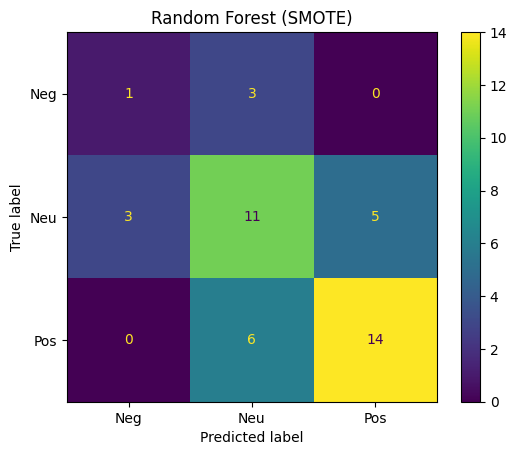

In [68]:

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

# Refit models
tree.fit(x_train_resampled, y_train_resampled)
evaluate_model(tree, "Decision Tree (SMOTE)")

gb.fit(x_train_resampled, y_train_resampled)
evaluate_model(gb, "Gradient Boosting (SMOTE)")

rf.fit(x_train_resampled, y_train_resampled)
evaluate_model(rf, "Random Forest (SMOTE)")
